## C_l sampler initial notes and tests

In [1]:
import os
import glob
import sys

import numpy as np
import healpy as hp

from scipy import signal
from scipy.fftpack import fft, fft2, fftshift, fftfreq
from scipy import integrate
from scipy.stats import invgamma

from pygdsm import GlobalSkyModel16
from pygdsm import GlobalSkyModel


# Plotting
#import matplotlib.pyplot as plt
import cmocean
import cmocean.cm as cmo
import seaborn as sns
import pylab as plt
import matplotlib as mpl
import matplotlib.pyplot as pyplot
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import (inset_axes, InsetPosition, mark_inset)
from matplotlib import ticker
# tango colors for colorpairs
sys.path.append("/Users/user/Documents/hera/tango-colors")
# from tango_colors import Tango
# tango = Tango('HTML')
import corner


# HYDRA (for HERA antennas)
sys.path.append("/Users/user/Documents/hera/Hydra") # change this to your own path
import hydra
from hydra.utils import build_hex_array

In [2]:
plt.rcParams['font.size'] = '18'
plt.rcParams['savefig.facecolor']='white'
plt.rcParams['axes.titlepad'] = 16
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif"
})
plt.rcParams["errorbar.capsize"] = 5

# Function definitions

## Mode conversion functions

### `healpy2alms`

In [3]:
def healpy2alms(healpy_modes):
    """
    Takes a complex array of alms (positive modes only) and turns into
    a real array split as [real, imag] making sure to remove the 
    m=0 modes from the imag-part.
      
     Parameters
    ----------
    * healpy_modes (ndarray (complex)):
            Array of zeros except for the specified mode. 
            The array represents all positive (+m) modes including zeroth modes.
    
    Returns
    -------
    * alms (ndarray (floats))
            Array of zeros except for the specified mode. 
            The array represents all positive (+m) modes including zero 
            and is split into a real (first) and imag (second) part. The
            Imag part is smaller as the m=0 modes shouldn't contain and 
            imaginary part. 
    """
    lmax = hp.sphtfunc.Alm.getlmax(healpy_modes.size) # to remove the m=0 imag modes
    alms = np.concatenate((healpy_modes.real,healpy_modes.imag[(lmax+1):]))
        
    return alms    


### `alms2healpy`

In [4]:
def alms2healpy(alms, lmax):
    """
    Takes a real array split as [real, imag] (without the m=0 modes 
    imag-part) and turns it into a complex array of alms (positive 
    modes only) ordered as in HEALpy.
      
     Parameters
    ----------
    * alms (ndarray (floats))
            The array represents all positive (+m) modes including zero 
            and has double length, as real and imaginary values are split. 
            The first half is the real values.

    
    Returns
    -------
    * healpy_modes (ndarray (complex)):
            Array of zeros except for the specified mode. 
            The array represents all positive (+m) modes including zeroth modes.
            
    """
    
    real_imag_split_index = int((np.size(alms)+(lmax+1))/2)
    real = alms[:real_imag_split_index]
    
    add_imag_m0_modes = np.zeros(lmax+1)
    imag = np.concatenate((add_imag_m0_modes, alms[real_imag_split_index:]))
    
    healpy_modes = real + 1.j*imag
    
    return healpy_modes

### `lm_order_alms`

In [5]:
def lm_order_alms(alms, lmax):
    """
    Takes a real array split as [real, imag] (without the m=0 modes 
    imag-part) ordered as (m,l) and reorders as (l,m) (still omitting
    the m=0 imaginary modes)
      
     Parameters
    ----------
    * alms (ndarray (floats))
            The array represents all positive (+m) modes including zero 
            and has double length, as real and imaginary values are split. 
            The first half is the real values.

    * lmax (integer)
            The maximum ell-value 

    
    Returns
    -------
    * healpy_modes (ndarray (complex)):
            Array of zeros except for the specified mode. 
            The array represents all positive (+m) modes including zeroth modes.
            
    """
    
    healpy_modes = alms2healpy(alms,lmax)

    # intialise for-loop
    real_modes = np.zeros_like(healpy_modes.real)
    imag_modes = np.zeros_like(healpy_modes.imag[(lmax+1):])
    real_idx = 0
    imag_idx = 0
    
    for ell in np.arange(0,lmax+1):
        for em in np.arange(0,ell+1): 
            healpy_idx = hp.sphtfunc.Alm.getidx(lmax, ell, em)
            real_modes[real_idx] = healpy_modes[healpy_idx].real
            real_idx +=1
            
            if em != 0:
                imag_modes[imag_idx] = healpy_modes[healpy_idx].imag
                imag_idx +=1

    return np.concatenate((real_modes, imag_modes))


### `get_em_ell_idx`

In [6]:
def get_em_ell_idx(lmax):
    """
    Function to get the em, ell, and index of all the modes given the lmax. 
    (m,l)-ordering, (m-major ordering)

    Parameters
    ----------
    * lmax: (int)
        Maximum ell value for alms

    Returns
    -------
    * ems: (list (int))
        List of all the em values of the alms (m,l)-ordering (m-major)

    * ells: (list (int))
        List of all the ell values of the alms (m,l)-ordering (m-major)
        
    * idx: (list (int)) 
        List of all the indices for the alms

    """

    ells_list = np.arange(0,lmax+1)
    em_real = np.arange(0,lmax+1)
    em_imag = np.arange(1,lmax+1)
    
    Nreal = 0
    i = 0
    idx = []
    ems = []
    ells = []

    for em in em_real:
        for ell in ells_list:
            if ell >= em:
                idx.append(i)
                ems.append(em)
                ells.append(ell)
                
                Nreal += 1
                i +=1
    
    Nimag=0

    for em in em_imag:
        for ell in ells_list:
            if ell >= em:
                idx.append(i)
                ems.append(em)
                ells.append(ell)

                Nimag += 1
                i += 1

    return ems, ells, idx

### `find_common_true_index`

In [7]:
def find_common_true_index(arr_em, arr_ell, lmax):
    """
    Find the common index between two arrays of same length consisting of true and false.

    Parameters
    ----------
    * arr_em: (ndarray (boolean))
        The m array to compare, consisting of true and false

    * arr_ell: (ndarray (boolean))
        The ell array to compare, consisting of true and false

    Returns
    -------
    * idx_real: (int)
        The common index for the real part

    * idx_imag: (int)
        The common index for the imag part

    """
    real_imag_split_index = int(((lmax+1)**2 + (lmax+1))/2)

    real_idx = []
    imag_idx = []

    for idx in range(len(arr_em)):
        if arr_em[idx] and arr_ell[idx] and idx < real_imag_split_index:
            real_idx = idx
        elif arr_em[idx] and arr_ell[idx] and idx >= real_imag_split_index:
            imag_idx = idx

    return real_idx, imag_idx


### `get_idx_ml`

In [8]:
def get_idx_ml(em, ell, lmax):
    """
    Get the global index for the alms (m,l)-ordering (m-major) given a m 
    and ell value. 
    
    Parameters
    ----------
    * em: (int)
        The em value of the mode. Note, em cannot be greater than the ell value.

    * ell: (int)
        The ell value of the mode. Note, ell has to be larger or equal to the em value.

    * lmax: (int)
        The lmax of the modes

    Returns
    -------
    * common_idx_real: (int)
        The global index of the real part of the spherical harmonic mode

    * common_idx_imag: (int)
        The global index of the imaginary part of the spherical harmonic mode. 
        There are no m=0 imaginary mode, so in case of m=0 it returns and empty list [].

    """

    assert np.all(em <= ell), "m cannot be greater than the ell value"
    ems_idx, ells_idx, idx = get_em_ell_idx(lmax)

    em_check = np.array(ems_idx) == em
    ell_check = np.array(ells_idx) == ell

    common_idx_real, common_idx_imag = find_common_true_index(arr_em=em_check,
                                                              arr_ell=ell_check,
                                                              lmax=lmax)
    if common_idx_imag == []:
        idx_list = [common_idx_real]
    else:
        idx_list = [common_idx_real, common_idx_imag]
        
    for common_idx in idx_list:
        assert common_idx == idx[common_idx], "the global index does not match the index list"
        assert em == ems_idx[common_idx], "The em corresponding to the global index does not match the chosen em"
        assert ell == ells_idx[common_idx], "The ell corresponding to the global index does not match the vhosen ell"

    return common_idx_real, common_idx_imag

### `get_em_labels`

In [9]:
def get_em_labels(lmax):
    ells = np.arange(0,lmax+1)
    em_real = np.arange(0,lmax+1) 
    em_imag = np.arange(1,lmax+1)

    # ylabel = []
    # First append all real (l,m) values
    Nreal = 0
    i = 0
    idx = []
    ems = []
    for em in em_real:
        for ell in ells:
            if ell >= em:
                # ylabel.append((ell, em))
                if ell == em:
                    idx.append(i)
                    if ell == 0:
                        ems.append(fr'$m= {em}$')
                    else:
                        ems.append(fr'${em}$')
                Nreal += 1
                i += 1

    # Then all imaginary -- note: no m=0 modes!  
    Nimag = 0
    for em in em_imag:
        for ell in ells:
            if ell >= em:
                # ylabel.append((ell,em))
                if ell == em:
                    idx.append(i)
                    ems.append(fr'${em}$')
                Nimag += 1
                i += 1
    return ems, idx

### `get_healpy_from_gsm`

In [10]:
def get_healpy_from_gsm(freq, lmax, nside=64, resolution="low", output_model=False, output_map=False):
    """
    Generate an array of alms (HEALpy ordered) from gsm 2016 (https://github.com/telegraphic/pygdsm)
    
    Parameters
    ----------
    * freqs: (float or np.array)
        Frequency (in MHz) for which to return GSM model
        
    * lmax: (int)
        Maximum l value for alms
        
    * nside: (int)
        The NSIDE you want to upgrade/downgrade the map to. Default is nside=64.

    * resolution: (str)
        if "low/lo/l":  The GSM nside = 64  (default)
        if "hi/high/h": The GSM nside = 1024 

    * output_model: (Boolean) optional
        If output_model=True: Outputs model generated from the GSM data. 
        If output_model=False (default): no model output.

    * output_map: (Boolean) optional
        If output_map=True: Outputs map generated from the GSM data. 
        If output_map=False (default): no map output.

    Returns
    -------
    *healpy_modes: (np.array)
        Complex array of alms with same size and ordering as in healpy (m,l)
    
    *gsm_2016: (PyGDSM 2016 model) optional
        If output_model=True: Outputs model generated from the GSM data. 
        If output_model=False (default): no model output.

    *gsm_map: (healpy map) optional
        If output_map=True: Outputs map generated from the GSM data. 
        If output_map=False (default): no map output.
    
    """
    gsm_2016 = GlobalSkyModel16(freq_unit='MHz', resolution=resolution) 
    gsm_map = gsm_2016.generate(freqs=freq)
    gsm_upgrade = hp.ud_grade(gsm_map, nside)
    healpy_modes_gal = hp.map2alm(maps=gsm_upgrade,lmax=lmax)

    # Per default it is in gal-coordinates, convert to equatorial
    rot_gal2eq = hp.Rotator(coord="GC")
    healpy_modes_eq = rot_gal2eq.rotate_alm(healpy_modes_gal)

    if output_model == False and output_map == False: # default
        return healpy_modes_eq
    elif output_model == False and output_map == True:
        return healpy_modes_eq, gsm_map 
    elif output_model == True and output_map == False:
        return healpy_modes_eq, gsm_2016 
    else:
        return healpy_modes_eq, gsm_2016, gsm_map

# Main

In [11]:
nside = 64
lmax = 100
healpy_alms = get_healpy_from_gsm(freq=100,lmax=lmax, nside=nside)
alms = healpy2alms(healpy_alms)

In [12]:
    # idxs_l = np.where(ell_vals == ell)
    # for em in em_vals[idxs_l]:
    #     idx_lm = idxs_l[0][em]
    #     if em == 0:
    #         sigma_ell[ell-1] = healpy_alms[idx_lm].real * healpy_alms[idx_lm].real
    #     else:
    #         sigma_ell[ell-1] += 2 * (healpy_alms[idx_lm].real * healpy_alms[idx_lm].real + 
    #                                  healpy_alms[idx_lm].imag * healpy_alms[idx_lm].imag)

In [13]:
def get_sigma_ell(alms, lmax):
    """
    Caculates sigma_ell for the angular powerspectrum given a set of 
    alms and an lmax. The alms are 'realified' i.e. flattened with first
    the real-part and then the imaginary part. Note, there should be no
    m=0 imaginary modes. The alms are (m,l)-ordered (m-major).

      
    Parameters
    ----------
    * alms (ndarray (floats))
            The array represents all positive (+m) modes including zero 
            and has double length, as real and imaginary values are split. 
            The first half is the real values.

    * lmax: (int)
            The lmax of the modes

    Returns
    -------
    * sigma_ell (ndarray (floats))
            An array of sigma_ell values for the angular power spectrum.

    """
    
    sigma_ell = np.zeros(shape=((lmax+1)-1))
    
    # Calculate sigma_ell = 1/(2 l + 1) sum_m |a_lm|^2
    for ell in np.arange(1,lmax+1):
        real_idx, _ = get_idx_ml(0,ell,lmax)
        sigma_ell[ell-1] = alms[real_idx] * alms[real_idx]
    
        for em in np.arange(1,ell+1):
            real_idx, imag_idx =  get_idx_ml(em, ell, lmax)
            sigma_ell[ell-1] += 2 * (alms[real_idx] * alms[real_idx] + 
                                     alms[imag_idx] * alms[imag_idx])
        
        sigma_ell[ell-1] /= 2*ell + 1 

    return sigma_ell

sigma_ell = get_sigma_ell(alms, lmax)

In [14]:
# def get_sigma_ell_hp(healpy_modes, lmax):

#     # excluding ell=0 because it's not defined for the invgamma func.
#     sigma_ell_hp = np.zeros(shape=((lmax+1)-1))
    
#     # Calculate sigma_ell = 1/(2 l + 1) sum_m |a_lm|^2
#     for ell in np.arange(1,lmax+1):
#         idx = hp.sphtfunc.Alm.getidx(lmax, ell, 0)
#         sigma_ell_hp[ell-1] = healpy_modes[idx].real * healpy_modes[idx].real
    
#         for em in np.arange(1,ell+1):
#             idx =  hp.sphtfunc.Alm.getidx(lmax, ell, em)
#             sigma_ell_hp[ell-1] += 2 * (healpy_modes[idx].real * healpy_modes[idx].real + 
#                                      healpy_modes[idx].imag * healpy_modes[idx].imag)
        
#         sigma_ell_hp[ell-1] /= 2*ell + 1 

#     return sigma_ell_hp

# sigma_ell_hp = get_sigma_ell_hp(healpy_alms, lmax)

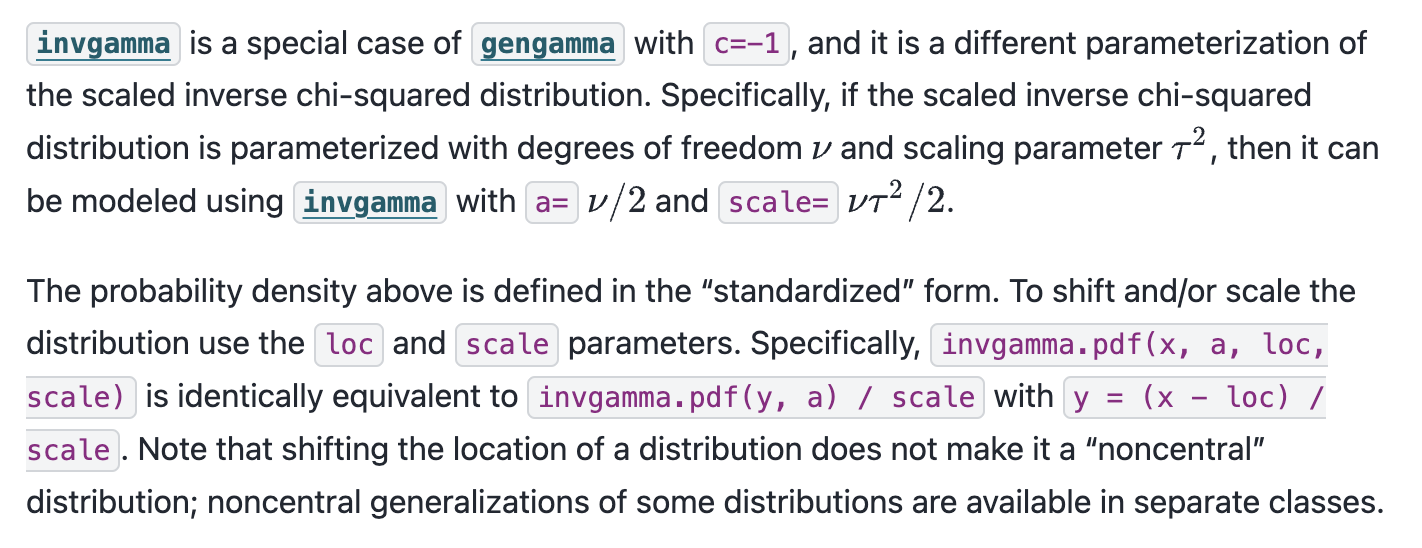

In [15]:
def get_cl_samples(alms, lmax):

    sigma_ell = get_sigma_ell(alms, lmax)
    
    unique_ell = np.arange(1,lmax+1)
    a = (2*unique_ell-1)/2
    cl_samples = invgamma.rvs(a,loc=0,scale=1)
    cl_samples *= sigma_ell * (2*unique_ell + 1)/2

    return cl_samples
    

array([ 3.91596358e+03, -3.56290784e+02,  5.29296203e+01, ...,
        1.72119635e-02, -2.37391808e-03, -1.43033834e-02])

In [30]:
def set_signal_cov_by_cl(prior_cov, cl_samples, lmax):
    """ 
    diagonal  matrix = just define the diagonal as an array
    """

    # The C_l function is not defined for ell=0, use prior_cov instead
    signal_cov = prior_cov.copy()

    # Then update all other entries (ell>0) 
    for ell in np.arange(1,lmax+1):
        real_idx, _ = get_idx_ml(0,ell,lmax)
        signal_cov[real_idx] = cl_samples[ell-1]
    
        for em in np.arange(1,ell+1):
            real_idx, imag_idx =  get_idx_ml(em, ell, lmax)
            signal_cov[real_idx] = cl_samples[ell-1]
            signal_cov[imag_idx] = cl_samples[ell-1]

    return signal_cov

prior_cov = (0.1 * alms)**2.
cl_samples = get_cl_samples(alms, lmax)
S_mat = set_signal_cov_by_cl(prior_cov, cl_samples, lmax)
S_mat.shape

(10201,)

In [ ]:
# def cl_samples(alms, lmax):

#     sigma_ell = get_sigma_ell(alms, lmax)
    
#     unique_ell = np.arange(1,lmax+1)
#     a = (2*unique_ell-1)/2
#     cl_samples = np.array([invgamma.rvs(a,loc=0,scale=1) for i in range(1000)]) 
#     cl_samples *= sigma_ell * (2*unique_ell + 1)/2

#     return cl_samples

In [ ]:
# unique_ell = np.arange(1,lmax+1)
# a = (2*unique_ell-1)/2

# Generate array of 1000 samples
# samples = np.array([invgamma.rvs(a,loc=0,scale=1) for i in range(1000)])  # default settings. Phil had loc=1 for some reason?
# samples.shape

In [ ]:
# Take the mean of the samples and calculate angular_cl
# angular_cl = sigma_ell * (2*unique_ell + 1)/2 * np.mean(samples, axis=0)
# cl_err = sigma_ell * (2*unique_ell + 1)/2 * np.std(samples, axis=0)

samples = cl_samples(alms,lmax)
angular_cl = np.mean(samples, axis=0)
cl_err = np.std(samples, axis=0)

In [17]:
# calculate cl via healpy for comparison
hp_cl = hp.sphtfunc.alm2cl(healpy_alms)

In [19]:
healpy_alms

array([ 3.91596358e+03+0.j        , -3.56290784e+02+0.j        ,
        5.29296203e+01+0.j        , ..., -1.90320673e-02+0.01721196j,
       -2.27343367e-02-0.00237392j,  3.46146794e-02-0.01430338j])

In [18]:
hp_cl.size

101

In [ ]:
plt.figure(figsize=(16,6))
plt.errorbar(x=unique_ell, 
             y= angular_cl,
             yerr= cl_err,
             fmt='o',
             alpha=0.7, label='mean, 1000 samples')
plt.plot(unique_ell, hp_cl[1:], 'o', alpha=0.7, label='healpy')
plt.yscale('log')
plt.legend()
_ = plt.xticks(np.arange(1, lmax+1, step=10))
# plt.xlim([50,101])

In [ ]:
cutoff = 10
plt.figure(figsize=(10,6))
plt.errorbar(x=unique_ell[cutoff-1:], 
             y= angular_cl[cutoff-1:]/hp_cl[cutoff:],
             yerr= cl_err[cutoff-1:]/hp_cl[cutoff:],
             fmt='o',
             alpha=0.7, label='(mean 1000 samples)/healpy')
# plt.plot(unique_ell, hp_cl[1:], 'o', alpha=0.7, label='healpy')
# plt.yscale('log')
plt.legend()
_ = plt.xticks(np.arange(cutoff, lmax+1, step=10))
plt.xlabel(r'$\ell$')
plt.ylabel(r'$C_{\ell}$')
plt.axhline(1, ls='--', color='black')

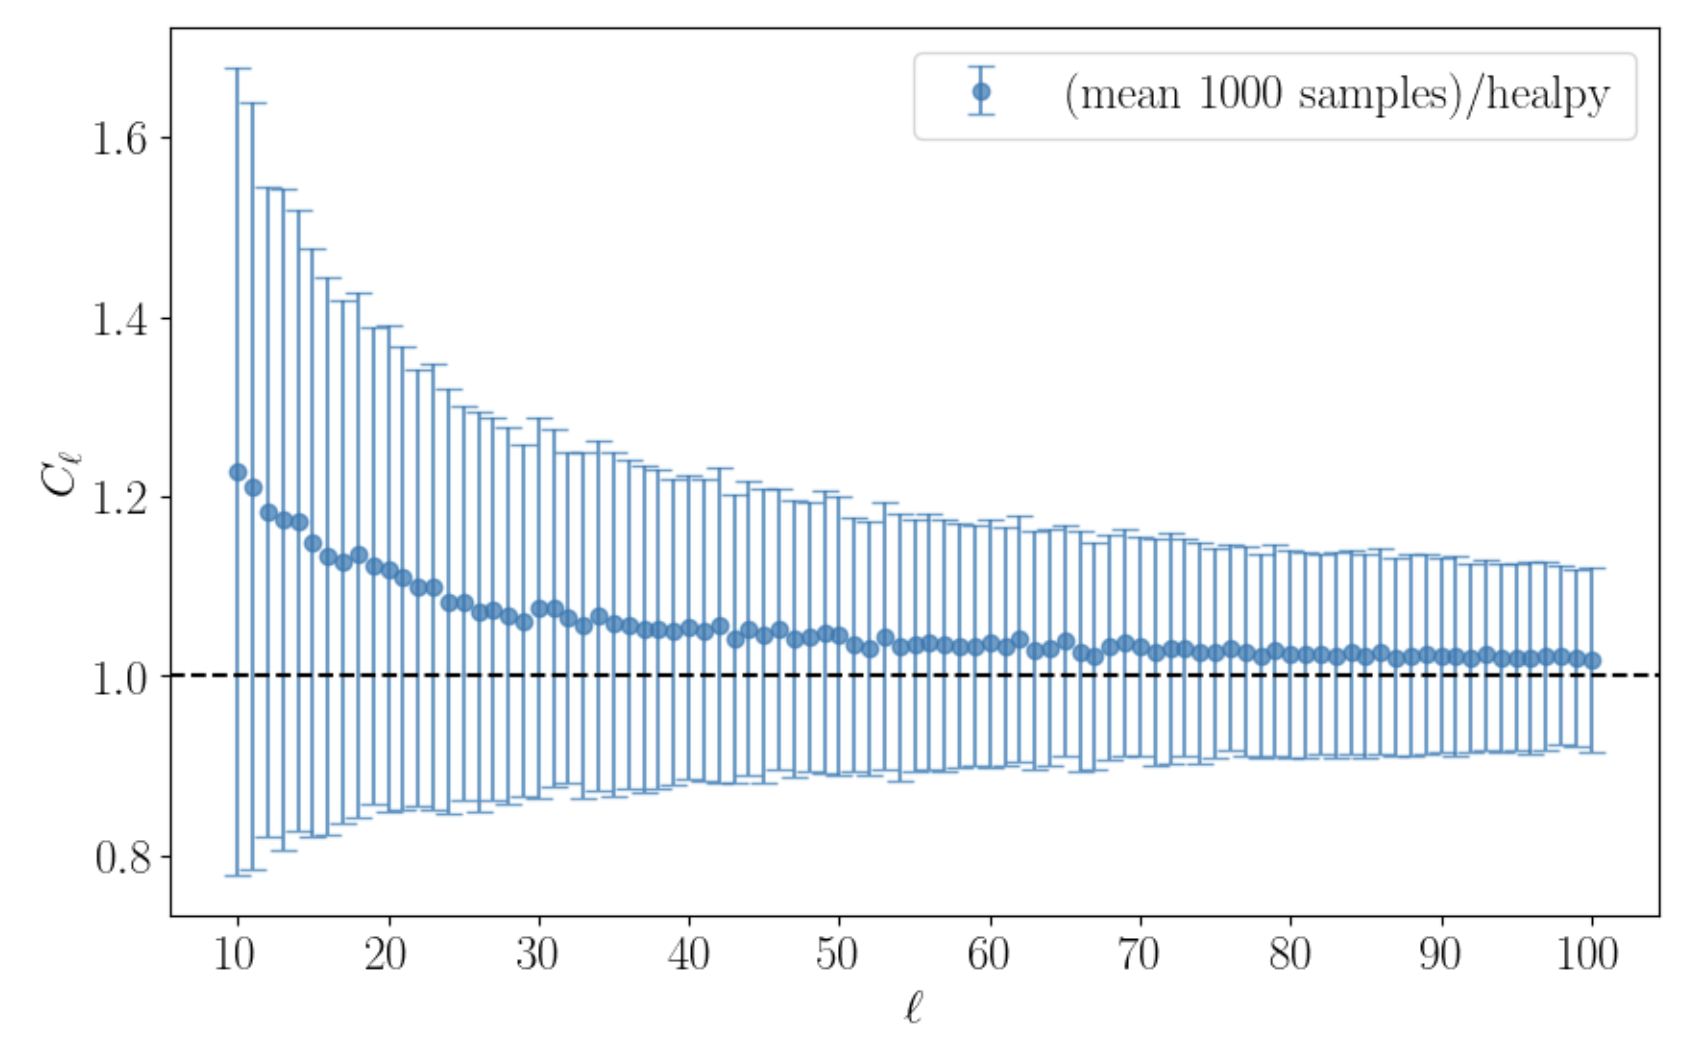

In [ ]:
for i in range(5):
    np.random.seed(i)
    samples = cl_samples(alms,lmax)
    plt.plot(unique_ell[9:], np.mean(samples, axis=0)[9:]/hp_cl[10:])
    # plt.yscale('log')

## Test of LinearOperator wrapper function

In [ ]:
import numpy as np
from scipy.sparse.linalg import LinearOperator

# Define the function that will be used for matvec
def f(x, c_array):
    return x * c_array

# Define the wrapper function that references c_array
def matvec(x):
    return f(x, c_array)

# Now define c_array after the functions
c_array = np.array([1, 2, 3])

# Define the LinearOperator using the wrapper function
n = 3
A = LinearOperator((n, n), matvec=matvec)

# Test with the initial c_array
x = np.array([1, 2, 3])
print("Initial result:", A @ x)  # Output should be [1, 4, 9]

# Modify c_array later
c_array = np.array([2, 4, 6])

# Test with the updated c_array
print("Updated result:", A @ x)  # Output should be [2, 8, 18]

In [ ]:
import numpy as np

inv_prior_cov = np.array([[1, 2], [3, 4]])
inv_signal_cov = inv_prior_cov

# Modify inv_signal_cov
inv_signal_cov[0, 0] = 99

# Both arrays are affected
print("inv_signal_cov:\n", inv_signal_cov)
print("inv_prior_cov:\n", inv_prior_cov)

In [ ]:
import numpy as np

inv_prior_cov = np.array([[1, 2], [3, 4]])
inv_signal_cov = inv_prior_cov.copy()

# Modify inv_signal_cov
inv_signal_cov[0, 0] = 99

# Both arrays are affected
print("inv_signal_cov:\n", inv_signal_cov)
print("inv_prior_cov:\n", inv_prior_cov)

In [ ]:
std_dev = 5
alm_test =  std_dev * np.random.randn(alms.size) + 1 

In [ ]:
# Calculate sigma_ell = 1/(2 l + 1) sum_m |a_lm|^2
for ell in np.arange(1,lmax+1):
    real_idx, _ = get_idx_ml(0,ell,lmax)
    sigma_ell[ell-1] = alms[real_idx] * alms[real_idx]

    for em in np.arange(1,ell+1):
        real_idx, imag_idx =  get_idx_ml(em, ell, lmax)
        sigma_ell[ell-1] += 2 * (alm_test[real_idx] * alm_test[real_idx] + 
                                 alm_test[imag_idx] * alm_test[imag_idx])
    
    sigma_ell[ell-1] /= 2*ell + 1 

sigma_ell